### Import libraries

In [1]:
import sys
sys.path.append("../")

In [2]:
import os
from os import environ
import numpy as np
from random import choices
import pandas as pd
from tqdm.notebook import tqdm

In [3]:
import skimage.io as io

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.transforms as mtrans
%matplotlib inline

In [5]:
from preprocess.common import load_nii

In [6]:
from torch.utils.data import DataLoader
from torchcontrib.optim import SWA

# ---- My utils ----
from utils.data_augmentation import data_augmentation_selector
from utils.dataload import *
from utils.training import *

In [7]:
train_aug, train_aug_img, val_aug = data_augmentation_selector("none", 224, 224)

Using None Data Augmentation


In [8]:
data_partition = "train"
general_aug, img_aug = train_aug, train_aug_img
normalization = "reescale"
fold_system = "patient"
label_type = "vendor_label_full"
data_fold = 0


train_dataset = MMsDataset(
    mode=data_partition, transform=general_aug, img_transform=img_aug,
    folding_system=fold_system, normalization=normalization, label_type=label_type,
    train_fold=data_fold, val_fold=None,
)

In [9]:
data_partition = "validation"
general_aug, img_aug = train_aug, train_aug_img
normalization = "reescale"
fold_system = "patient"
label_type = "vendor_label_full"
data_fold = 0


val_dataset = MMsDataset(
    mode=data_partition, transform=general_aug, img_transform=img_aug,
    folding_system=fold_system, normalization=normalization, label_type=label_type,
    train_fold=data_fold, val_fold=None,
)

---------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------

In [10]:
train_dataset.df.head()

,External code,Vendor,Centre,Labeled,Type,Phase,Slice
0,A0S9V9,A,1,True,ED,0,0
1,A0S9V9,A,1,True,ED,0,1
2,A0S9V9,A,1,True,ED,0,2
3,A0S9V9,A,1,True,ED,0,3
4,A0S9V9,A,1,True,ED,0,4


In [11]:
val_dataset.df.head()

,External code,Vendor,Centre,Labeled,Type,Phase,Slice
0,A3B7E5,B,2,True,ED,29,0
1,A3B7E5,B,2,True,ED,29,1
2,A3B7E5,B,2,True,ED,29,2
3,A3B7E5,B,2,True,ED,29,3
4,A3B7E5,B,2,True,ED,29,4


#### Value counts

In [12]:
train_dataset.df.Vendor.value_counts()

A    1428
B    1220
C     436
Name: Vendor, dtype: int64

In [13]:
val_dataset.df.Vendor.value_counts()

B    326
A    310
C    138
Name: Vendor, dtype: int64

#### Patient intersection

In [14]:
np.intersect1d(train_dataset.df["External code"].unique(), val_dataset.df["External code"].unique())

array([], dtype=object)

-------------------------

-------------------------

-------------------------

-------------------------

-------------------------

-------------------------

-------------------------

-------------------------

In [19]:
train_aug, train_aug_img, val_aug = data_augmentation_selector("none", 224, 224)

Using None Data Augmentation


In [20]:
data_partition = "validation"
general_aug, img_aug = train_aug, train_aug_img
normalization = "none"  # "standardize" no normalization, we will apply it later on apply() at ImageBackwardEntropy
fold_system = "vendor"
label_type = "mask"

segmentation_train_fold = 'A'
segmentation_val_fold = 'B'

In [21]:
segmentation_val_dataset = MMsDataset(
    mode=data_partition, transform=general_aug, img_transform=img_aug,
    folding_system=fold_system, normalization=normalization, label_type=label_type,
    train_fold=segmentation_train_fold, val_fold=segmentation_val_fold,
)

segmentation_loader = DataLoader(segmentation_val_dataset, batch_size=1, shuffle=False, drop_last=False)

Possible vendor folds: ['A' 'B'] - Using Vendor 'B'


In [22]:
sample_break = 32
for sample_indx, (image, original_image, original_mask, mask, img_id) in enumerate(segmentation_loader):
    if sample_indx == sample_break:
        break

In [23]:
image

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])

In [66]:
unblur_param = 0.05
unblurring_matrix = torch.tensor(
            [[-unblur_param, -unblur_param, -unblur_param],
             [-unblur_param, 1 + 8 * unblur_param, -unblur_param],
             [-unblur_param, -unblur_param, -unblur_param]],
            requires_grad=False)
unblurring_matrix

tensor([[-0.0500, -0.0500, -0.0500],
        [-0.0500,  1.4000, -0.0500],
        [-0.0500, -0.0500, -0.0500]])

In [67]:
unblurring_matrix / unblurring_matrix.sum()

tensor([[-0.0500, -0.0500, -0.0500],
        [-0.0500,  1.4000, -0.0500],
        [-0.0500, -0.0500, -0.0500]])

In [68]:
transformed = torch.nn.functional.conv2d(
    image.float(), unblurring_matrix.unsqueeze(0).unsqueeze(0).float(),
    padding=1, stride=1
)

In [69]:
print(f"Image max: {image.max()}")
print(f"Image min: {image.min()}")
print(f"Image mean: {image.mean()}")
print(f"Image std: {image.std()}")

Image max: 2334.804443359375
Image min: 0.0
Image mean: 395.854736328125
Image std: 470.6990661621094


In [70]:
print(f"Transformed max: {transformed.max()}")
print(f"Transformed min: {transformed.min()}")
print(f"Transformed mean: {transformed.mean()}")
print(f"Transformed std: {transformed.std()}")

Transformed max: 2565.8525390625
Transformed min: -341.1556091308594
Transformed mean: 396.4244384765625
Transformed std: 482.4624328613281


In [71]:
image_standardidez = apply_batch_local_torch_normalization(copy.deepcopy(image).detach(), "standardize")
transformed_standardidez = apply_batch_local_torch_normalization(copy.deepcopy(transformed).detach(), "standardize")

(-0.5, 223.5, 223.5, -0.5)

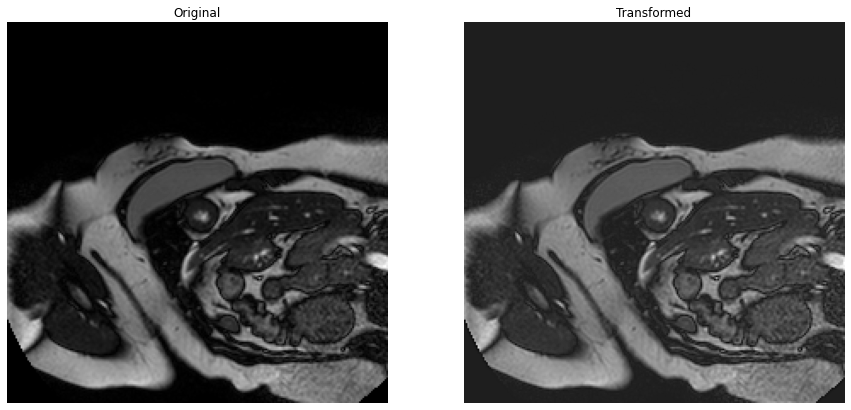

In [72]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 20))

ax1.set_title("Original")
ax1.imshow(image.cpu().detach().squeeze(0).squeeze(0), cmap="gray")
ax1.axis("off")

ax2.set_title("Transformed")
ax2.imshow(transformed.cpu().detach().squeeze(0).squeeze(0), cmap="gray")
ax2.axis("off")

In [34]:
image_standardidez

tensor([[[[-0.8410, -0.8410, -0.8410,  ..., -0.8410, -0.8410, -0.8410],
          [-0.8410, -0.8410, -0.8410,  ..., -0.8410, -0.8410, -0.8410],
          [-0.8410, -0.8410, -0.8410,  ..., -0.8410, -0.8410, -0.8410],
          ...,
          [-0.8410, -0.8410, -0.8410,  ..., -0.8410, -0.8410, -0.8410],
          [-0.8410, -0.8410, -0.8410,  ..., -0.8410, -0.8410, -0.8410],
          [-0.8410, -0.8410, -0.8410,  ..., -0.8410, -0.8410, -0.8410]]]])

In [32]:
transformed_standardidez

tensor([[[[-0.4395, -0.4395, -0.4395,  ..., -0.4395, -0.4395, -0.4395],
          [-0.4395, -0.4395, -0.4395,  ..., -0.4395, -0.4395, -0.4395],
          [-0.4395, -0.4395, -0.4395,  ..., -0.4395, -0.4395, -0.4395],
          ...,
          [-0.4395, -0.4395, -0.4395,  ..., -0.4395, -0.4395, -0.4395],
          [-0.4395, -0.4395, -0.4395,  ..., -0.4395, -0.4395, -0.4395],
          [-0.4395, -0.4395, -0.4395,  ..., -0.4395, -0.4395, -0.4395]]]])

In [35]:
image

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])

In [33]:
transformed

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])

(-0.5, 223.5, 223.5, -0.5)

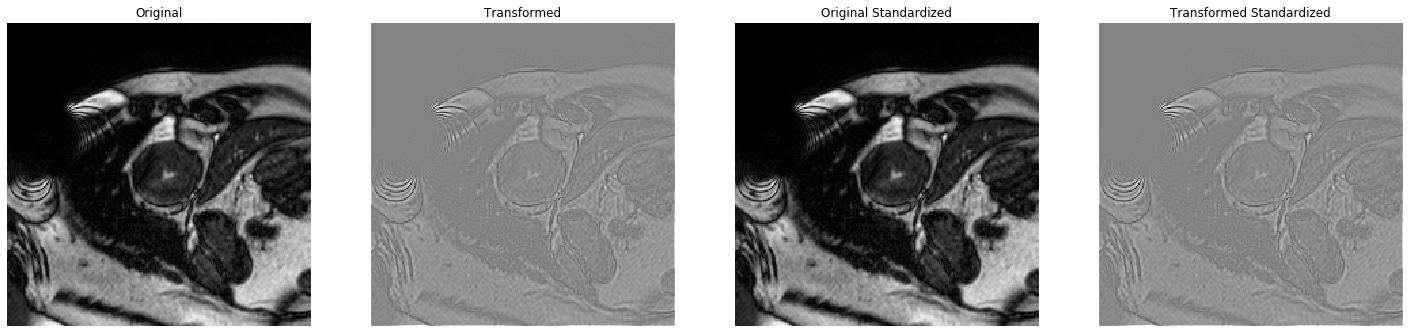

In [72]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(25, 40))

ax1.set_title("Original")
ax1.imshow(image.cpu().detach().squeeze(0).squeeze(0), cmap="gray")
ax1.axis("off")

ax2.set_title("Transformed")
ax2.imshow(transformed.cpu().detach().squeeze(0).squeeze(0), cmap="gray")
ax2.axis("off")

ax3.set_title("Original Standardized")
ax3.imshow(image_standardidez.cpu().detach().squeeze(0).squeeze(0), cmap="gray")
ax3.axis("off")

ax4.set_title("Transformed Standardized")
ax4.imshow(transformed_standardidez.cpu().detach().squeeze(0).squeeze(0), cmap="gray")
ax4.axis("off")